## Metadata Analysis
Purpose of this notebook is to perform analysis on the metadata of the cohort we have extracted.

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

# Target = 1

In [2]:
with open("metadata18v2/met150000.pkl","rb") as openfile: # this file is extremely large
    metadata = pickle.load(openfile)   

In [3]:
metadata = pd.DataFrame(metadata, columns = ["username","type","subreddit","date","text","ups","downs","num_response"])
metadata['date'] = pd.to_datetime(metadata['date'], infer_datetime_format=True)
print(str(len(metadata.username.unique())) + " unique users found!")
display(metadata.head(), metadata.shape)

76193 unique users found!


,username,type,subreddit,date,text,ups,downs,num_response
0,FrankLamps,0,SuicideWatch,2018-08-11 10:08:28,I don't think she's pregant.. and my God what ...,1,0,0
1,FrankLamps,0,SuicideWatch,2018-08-11 10:03:22,"how is it brighter.. to have a kid at 21, and ...",1,0,0
2,FrankLamps,0,cheating_stories,2018-08-07 07:02:37,"Yeah, was the cherry on top.",5,0,0
3,FrankLamps,0,cheating_stories,2018-08-07 07:02:26,almost a year..,5,0,0
4,FrankLamps,0,cheating_stories,2018-08-06 11:42:43,"Thanks, the last couple of hours i've been thi...",16,0,0


(15653345, 8)

In [7]:
metadata_count = metadata.groupby('subreddit')\
            .nunique()['username']\
            .reset_index()\
            .rename({'username':'nunique'}, axis =1)

metadata_count.head()

,subreddit,nunique
0,007,2
1,00sAesthetics,1
2,00sBabies,1
3,00scartoons,1
4,00sdesign,1


List of subreddits related to potential causes for "despair". 

In [372]:
depression_list = ['depression','depression_help','antidepressants','depressed', 'AnxietyDepression', 'AdultDepression']

anxiety_list = ['Anxiety','AnxietyDepression','socialanxiety','Anxietyhelp','adhd_anxiety','PanicAttack']

bipolar_list = ['bipolar','BipolarReddit']

bpd_list = ['BPD']

ptsd_list = ['CPTSD','ptsd']

ocd_list = ['OCD']

addiction_list = ['addiction','alcoholism','alcohol','cripplingalcoholism','alcoholicsanonymous',\
                  'opiates','heroin','cocaine','trees','Drugs','askdrugs','leaves'] # alcohol, opioids, general drug usage

schizo_list = ['schizophrenia']

eating_disorder_list = ['BingeEatingDisorder','EatingDisorders','fuckeatingdisorders','eating_disorders','bulimia']

self_harm_list = ['selfharm','SelfHarmScars']

lonely_list = ['lonely','ForeverAlone']

# external causes
sexual_list = ['rape','rapecounseling','sexualassault']

relationship_list = ['relationship_advice','relationships','abusiverelationships','survivinginfidelity',\
                     'cheating_stories','NarcissisticAbuse','abusiveparents','survivorsofabuse',\
                     'raisedbynarcissists','insaneparents','BreakUps','heartbreak']
                     
traumatic_events = ['lossofalovedone','LostALovedOne']

## Cohort Filtering

Developing experimental group. 

1. Filter by users that had some activity (comment or post) in r/SuicideWatch
2. Filter by users that had some activity (comment or post) in MH subs 
3. Filter by users that had an r/SuicideWatch post
4. Filter by users that had mental health activity 
5. Filter by users that had mental health activity before r/SuicideWatch
6. Filter by users that had mental health activity on two different days (some sort of history of activity)
7. Filter by users that had at least [two] months since they last posted 
8. Filter by users that posted in an MH sub within the last year

In [71]:
metadata_count[metadata_count.subreddit\
                .apply(lambda x: x.lower()).str.contains('abus')]\
                .sort_values('nunique', ascending = False)[:20]

,subreddit,nunique
52852,abuse,591
31743,NarcissisticAbuse,457
52859,abusiverelationships,402
82083,survivorsofabuse,283
52857,abusiveparents,248
62106,emotionalabuse,216
1448,AbuseInterrupted,86
56101,bitchimabus,78
52853,abusesurvivors,72
55004,babushkadogs,36


In [374]:
SW_users = list(metadata[(metadata['subreddit']=='SuicideWatch') & (metadata['type']==1)].username.unique())
print(str(len(SW_users)) + " users made posts in SuicideWatch subreddit.")

48234 users made posts in SuicideWatch subreddit.


In [375]:
first_activity = metadata.loc[(metadata.groupby('username')['date'].idxmin())]
first_activity.head(n=3)

,username,type,subreddit,date,text,ups,downs,num_response
9077098,-------RS--------,1,lonely,2019-09-03 06:29:44,Truly A Bruh Moment Feel like some outside for...,8,0,14
6236045,----Kerosene----,1,SuicideWatch,2019-07-22 11:50:15,I’m just like the rest of you This is my first...,1,0,3
1464108,---9--7--,1,SuicideWatch,2019-09-05 04:34:17,Think I might do it Think I might kill myself ...,1,0,1


In [376]:
first_activity.shape

(48234, 8)

In [377]:
# list of users whose first activity was not SW
first_activity_nsw = first_activity[first_activity['subreddit'] != 'SuicideWatch'].username.unique().tolist()

In [378]:
nsw_first_users = list(set(SW_users).intersection(set(first_activity_nsw)))
print("Dropped from " + str(len(SW_users)) + " to " + str(len(nsw_first_users)) + " by filtering out users whose first post on reddit was the SW post. We want users that had a history of posting on reddit before eventually posting on SW. But this drop is significant as it shows us that a lot of the actual suicidal users don't necessarily have preexisting accounts.")
print("")
print("This is about a " + str(np.round((len(SW_users)-len(nsw_first_users))/len(SW_users) *100, 2)) + "% decrease") 

Dropped from 48234 to 30631 by filtering out users whose first post on reddit was the SW post. We want users that had a history of posting on reddit before eventually posting on SW. But this drop is significant as it shows us that a lot of the actual suicidal users don't necessarily have preexisting accounts.

This is about a 36.5% decrease


In [379]:
metnsw = metadata[metadata.username.isin(nsw_first_users)]
metnsw.head()

,username,type,subreddit,date,text,ups,downs,num_response
0,FrankLamps,0,SuicideWatch,2018-08-11 10:08:28,I don't think she's pregant.. and my God what ...,1,0,0
1,FrankLamps,0,SuicideWatch,2018-08-11 10:03:22,"how is it brighter.. to have a kid at 21, and ...",1,0,0
2,FrankLamps,0,cheating_stories,2018-08-07 07:02:37,"Yeah, was the cherry on top.",5,0,0
3,FrankLamps,0,cheating_stories,2018-08-07 07:02:26,almost a year..,5,0,0
4,FrankLamps,0,cheating_stories,2018-08-06 11:42:43,"Thanks, the last couple of hours i've been thi...",16,0,0


### First Non SW Post

Regardless of where it was posted.

In [380]:
first_activity_date = first_activity[['username','date']][first_activity.\
                                                          username.\
                                                          isin(nsw_first_users)].\
                                                         rename({'date':'first_act_date'},axis = 1)

In [381]:
first_activity_date

,username,first_act_date
9077098,-------RS--------,2019-09-03 06:29:44
4173058,---kali---,2020-01-28 00:09:51
1362387,--OriginalUsername--,2020-09-20 22:59:27
4127740,--Pascal--,2018-02-26 07:15:46
9628739,--Pot--,2019-11-02 21:42:09
...,...,...
4495143,zzcool,2012-03-16 08:44:22
1684872,zzmat,2016-08-31 19:44:55
8005581,zzubnik,2010-11-12 13:09:46
2929212,zzzinthev6446,2020-11-06 07:58:37


### First SW Post Date 

In [382]:
first_sw_dates = metnsw[(metnsw['subreddit'] == 'SuicideWatch')&(metnsw['type']==1)].groupby('username').date.agg(first_sw_post = np.min).reset_index()

In [383]:
first_sw_dates

,username,first_sw_post
0,-------RS--------,2019-09-10 01:12:53
1,---kali---,2020-05-07 07:53:43
2,--OriginalUsername--,2020-10-10 02:09:19
3,--Pascal--,2018-05-16 13:08:07
4,--Pot--,2020-08-23 15:23:40
...,...,...
30626,zzcool,2020-08-16 05:11:11
30627,zzmat,2019-06-14 03:59:17
30628,zzubnik,2018-12-31 23:02:51
30629,zzzinthev6446,2021-02-22 07:22:14


In [384]:
print(metnsw.shape)
metnsw = pd.merge(metnsw, first_sw_dates, on = 'username')
metnsw = metnsw[~(metnsw['date']>metnsw['first_sw_post'])]
print(metnsw.shape)

(9380515, 8)
(3914765, 9)


### First MH Post Date

In [385]:
MH_subs = depression_list + anxiety_list \
        + bpd_list + bipolar_list + ptsd_list \
        + ocd_list + addiction_list + schizo_list \
        + eating_disorder_list + self_harm_list \
        + lonely_list + sexual_list + relationship_list

In [386]:
display(MH_subs, "Number of subreddits in list : " + str(len(MH_subs)))

['depression',
 'depression_help',
 'antidepressants',
 'depressed',
 'AnxietyDepression',
 'AdultDepression',
 'Anxiety',
 'AnxietyDepression',
 'socialanxiety',
 'Anxietyhelp',
 'adhd_anxiety',
 'PanicAttack',
 'BPD',
 'bipolar',
 'BipolarReddit',
 'CPTSD',
 'ptsd',
 'OCD',
 'addiction',
 'alcoholism',
 'alcohol',
 'cripplingalcoholism',
 'alcoholicsanonymous',
 'opiates',
 'heroin',
 'cocaine',
 'trees',
 'Drugs',
 'askdrugs',
 'leaves',
 'schizophrenia',
 'BingeEatingDisorder',
 'EatingDisorders',
 'fuckeatingdisorders',
 'eating_disorders',
 'bulimia',
 'BreakUps',
 'heartbreak',
 'selfharm',
 'SelfHarmScars',
 'lonely',
 'ForeverAlone',
 'rape',
 'rapecounseling',
 'sexualassault',
 'relationship_advice',
 'relationships',
 'abusiverelationships',
 'survivinginfidelity',
 'cheating_stories',
 'NarcissisticAbuse',
 'abusiveparents',
 'survivorsofabuse',
 'raisedbynarcissists',
 'insaneparents',
 'lossofalovedone',
 'LostALovedOne']

'Number of subreddits in list : 57'

In [387]:
mh_users = metnsw[metnsw.subreddit.isin(MH_subs)].username.unique().tolist()
len(mh_users)

14438

In [388]:
first_mh_dates = metnsw[(metnsw.subreddit.isin(MH_subs))&(metnsw.username.isin(mh_users))].\
                         groupby('username').\
                         date.\
                         agg(first_mh_post = np.min, last_mh_post = np.max).\
                         reset_index()
first_mh_dates.head()

,username,first_mh_post,last_mh_post
0,-------RS--------,2019-09-03 06:29:44,2019-09-10 01:09:32
1,---kali---,2020-01-28 00:09:51,2020-05-04 13:06:11
2,--Pascal--,2018-02-28 04:13:43,2018-05-16 11:47:35
3,--Solus,2016-07-18 17:45:36,2017-04-18 10:34:33
4,--XCrissCrossX--,2020-02-26 09:53:50,2020-02-26 09:53:50


## User Posting Date Stats

In [389]:
user_date_activity = pd.merge(first_activity_date, first_sw_dates)
user_date_activity = pd.merge(user_date_activity, first_mh_dates)
user_date_activity.head()

,username,first_act_date,first_sw_post,first_mh_post,last_mh_post
0,-------RS--------,2019-09-03 06:29:44,2019-09-10 01:12:53,2019-09-03 06:29:44,2019-09-10 01:09:32
1,---kali---,2020-01-28 00:09:51,2020-05-07 07:53:43,2020-01-28 00:09:51,2020-05-04 13:06:11
2,--Pascal--,2018-02-26 07:15:46,2018-05-16 13:08:07,2018-02-28 04:13:43,2018-05-16 11:47:35
3,--Solus,2016-06-01 18:14:25,2017-06-19 13:16:56,2016-07-18 17:45:36,2017-04-18 10:34:33
4,--XCrissCrossX--,2020-02-26 09:53:50,2020-03-07 22:06:04,2020-02-26 09:53:50,2020-02-26 09:53:50


In [390]:
user_date_activity['time_since_first'] = \
        (user_date_activity['first_sw_post'] - user_date_activity['first_act_date']).\
        astype('timedelta64[D]')

user_date_activity['time_since_first_mh'] = \
        (user_date_activity['first_sw_post'] - user_date_activity['first_mh_post']).\
        astype('timedelta64[D]')

user_date_activity['time_since_last_mh'] = \
        (user_date_activity['first_sw_post'] - user_date_activity['last_mh_post']).\
        astype('timedelta64[D]')

In [391]:
user_date_activity.head()

,username,first_act_date,first_sw_post,first_mh_post,last_mh_post,time_since_first,time_since_first_mh,time_since_last_mh
0,-------RS--------,2019-09-03 06:29:44,2019-09-10 01:12:53,2019-09-03 06:29:44,2019-09-10 01:09:32,6.0,6.0,0.0
1,---kali---,2020-01-28 00:09:51,2020-05-07 07:53:43,2020-01-28 00:09:51,2020-05-04 13:06:11,100.0,100.0,2.0
2,--Pascal--,2018-02-26 07:15:46,2018-05-16 13:08:07,2018-02-28 04:13:43,2018-05-16 11:47:35,79.0,77.0,0.0
3,--Solus,2016-06-01 18:14:25,2017-06-19 13:16:56,2016-07-18 17:45:36,2017-04-18 10:34:33,382.0,335.0,62.0
4,--XCrissCrossX--,2020-02-26 09:53:50,2020-03-07 22:06:04,2020-02-26 09:53:50,2020-02-26 09:53:50,10.0,10.0,10.0


In [447]:
mh_users = user_date_activity[user_date_activity['first_mh_post'] < user_date_activity['first_sw_post']]
mh_users.head()

,username,first_act_date,first_sw_post,first_mh_post,last_mh_post,time_since_first,time_since_first_mh,time_since_last_mh
0,-------RS--------,2019-09-03 06:29:44,2019-09-10 01:12:53,2019-09-03 06:29:44,2019-09-10 01:09:32,6.0,6.0,0.0
1,---kali---,2020-01-28 00:09:51,2020-05-07 07:53:43,2020-01-28 00:09:51,2020-05-04 13:06:11,100.0,100.0,2.0
2,--Pascal--,2018-02-26 07:15:46,2018-05-16 13:08:07,2018-02-28 04:13:43,2018-05-16 11:47:35,79.0,77.0,0.0
3,--Solus,2016-06-01 18:14:25,2017-06-19 13:16:56,2016-07-18 17:45:36,2017-04-18 10:34:33,382.0,335.0,62.0
4,--XCrissCrossX--,2020-02-26 09:53:50,2020-03-07 22:06:04,2020-02-26 09:53:50,2020-02-26 09:53:50,10.0,10.0,10.0


In [448]:
mh_users.describe()

,time_since_first,time_since_first_mh,time_since_last_mh
count,14438.000000,14438.000000,14438.000000
mean,460.576396,260.386965,103.003325
std,597.597605,418.963793,247.817184
min,0.000000,0.000000,0.000000
25%,52.000000,16.000000,1.000000
50%,231.000000,98.000000,14.000000
75%,628.000000,313.000000,90.000000
max,4408.000000,3578.000000,3578.000000


In [449]:
mh_users.shape[0]

14438

In [450]:
sub_counts = metnsw.groupby(['username','subreddit']).count().reset_index()

In [451]:
sub_counts.head()

,username,subreddit,type,date,text,ups,downs,num_response,first_sw_post
0,-------RS--------,SuicideWatch,1,1,1,1,1,1,1
1,-------RS--------,TrueOffMyChest,4,4,4,4,4,4,4
2,-------RS--------,depression,3,3,3,3,3,3,3
3,-------RS--------,lonely,19,19,19,19,19,19,19
4,---kali---,Art,2,2,2,2,2,2,2


In [452]:
unique_subs = sub_counts[sub_counts.subreddit\
                            .isin(MH_subs)]\
                            .groupby('username')\
                            .subreddit.nunique()\
                            .reset_index()\
                            .rename({'subreddit': 'nunique_mh'}, axis = 1)

In [455]:
act_counts = sub_counts[sub_counts.subreddit\
                            .isin(MH_subs)]\
                            .groupby('username')\
                            .type.sum()\
                            .reset_index()\
                            .rename({'type': 'act_sum'}, axis = 1)

In [456]:
mh_user_info = pd.merge(unique_subs, act_counts, on = 'username')

In [457]:
mh_users = pd.merge(mh_user_info, mh_users, on = 'username')
mh_users.head()

,username,nunique_mh,act_sum,first_act_date,first_sw_post,first_mh_post,last_mh_post,time_since_first,time_since_first_mh,time_since_last_mh
0,-------RS--------,2,22,2019-09-03 06:29:44,2019-09-10 01:12:53,2019-09-03 06:29:44,2019-09-10 01:09:32,6.0,6.0,0.0
1,---kali---,5,32,2020-01-28 00:09:51,2020-05-07 07:53:43,2020-01-28 00:09:51,2020-05-04 13:06:11,100.0,100.0,2.0
2,--Pascal--,6,41,2018-02-26 07:15:46,2018-05-16 13:08:07,2018-02-28 04:13:43,2018-05-16 11:47:35,79.0,77.0,0.0
3,--Solus,4,8,2016-06-01 18:14:25,2017-06-19 13:16:56,2016-07-18 17:45:36,2017-04-18 10:34:33,382.0,335.0,62.0
4,--XCrissCrossX--,1,1,2020-02-26 09:53:50,2020-03-07 22:06:04,2020-02-26 09:53:50,2020-02-26 09:53:50,10.0,10.0,10.0


In [496]:
#user criteria
users_to_keep = mh_users[(mh_users['time_since_first']>250)&\
                (mh_users['first_mh_post']!=mh_users['last_mh_post'])&\
                (mh_users['time_since_last_mh']<365*2)].username.tolist()

In [497]:
len(users_to_keep)

5350

In [500]:
target_meta = metnsw[metnsw.username.isin(users_to_keep)]
target_meta.shape

(1663929, 9)

In [501]:
target_meta = target_meta.to_csv('target_1.csv', index = False)

In [306]:
metnsw[metnsw.username.isin(users_to_keep)].type.value_counts()

0    385900
1    107510
Name: type, dtype: int64

In [195]:
user_dist = metnsw[metnsw.subreddit.isin(MH_subs)].groupby('subreddit').nunique()['username'].reset_index().sort_values('username', ascending = False)

In [278]:
user_dist.to_csv('control_dist.csv', index = False)

<AxesSubplot:xlabel='username', ylabel='subreddit'>

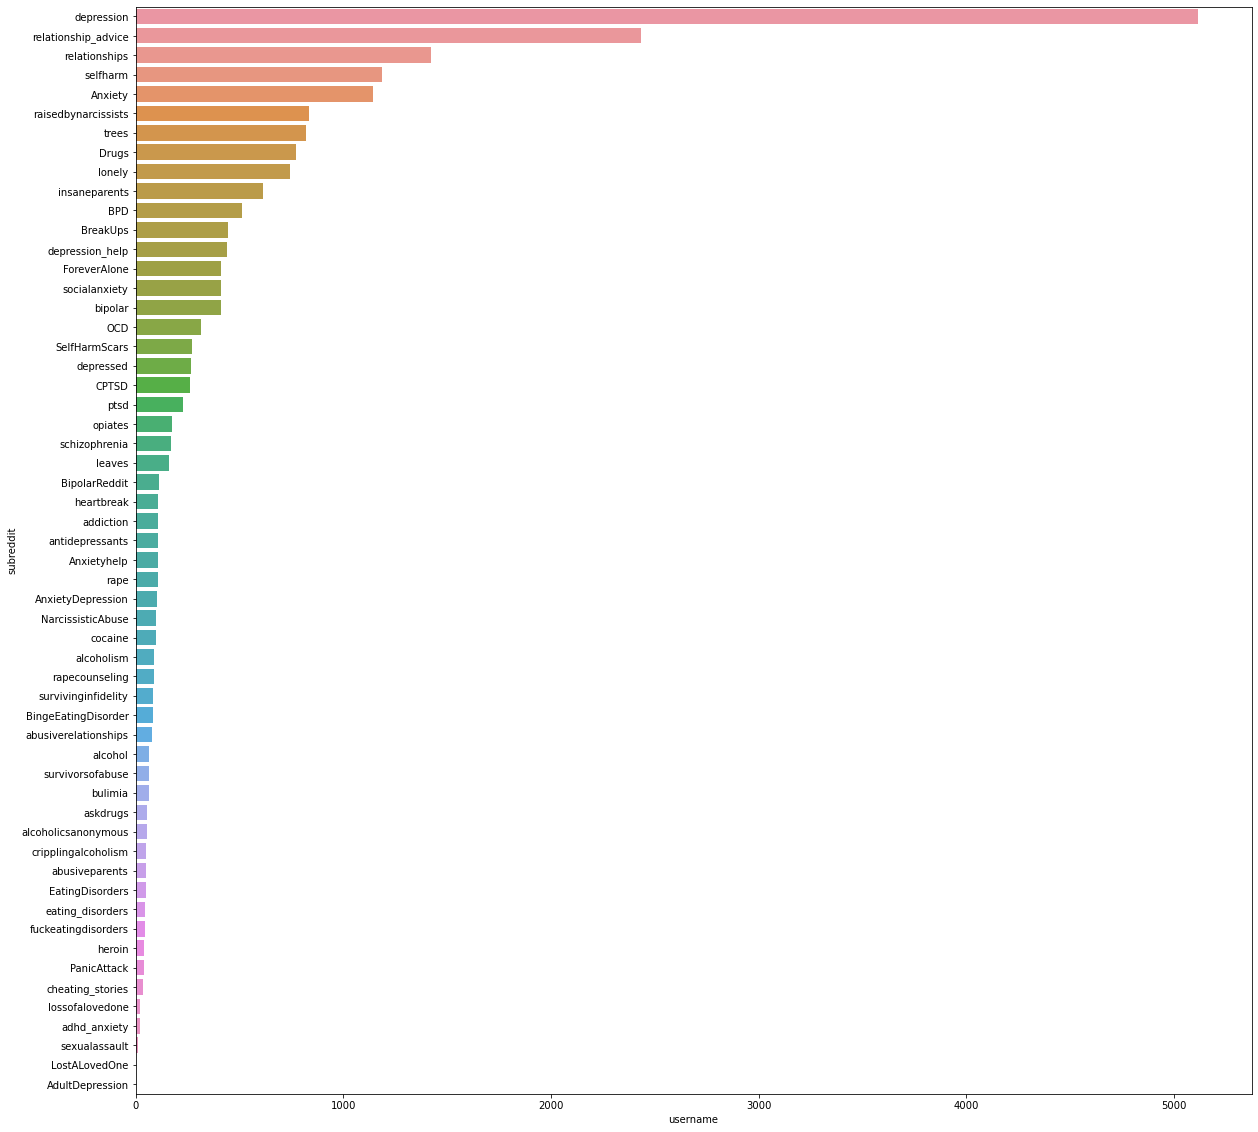

In [198]:
plt.figure(figsize=(20,20))
sns.barplot(x = 'username', y ='subreddit', data = user_dist)

Text(0, 0.5, 'Number of Users Left')

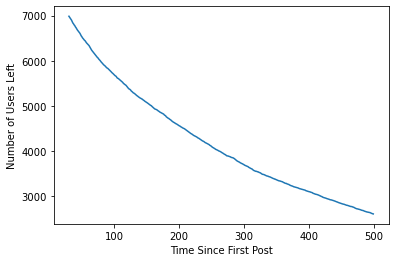

In [102]:
num_users = []
for i in range(30,500):
    num_users.append(mh_users[mh_users['time_since_first']>i].shape[0])
    
fig = plt.figure()
ax = plt.axes()

ax.plot(list(range(30,500)), num_users);
plt.xlabel('Time Since First Post')
plt.ylabel('Number of Users Left')

Text(0, 0.5, 'Number of Users Left')

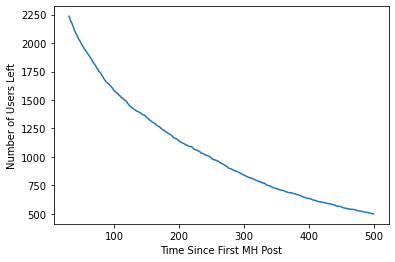

In [103]:
num_users = []
for i in range(30,500):
    num_users.append(mh_users[mh_users['time_since_first_mh']>i].shape[0])
    
fig = plt.figure()
ax = plt.axes()

ax.plot(list(range(30,500)), num_users);
plt.xlabel('Time Since First MH Post')
plt.ylabel('Number of Users Left')

Text(0, 0.5, 'Number of Users Left')

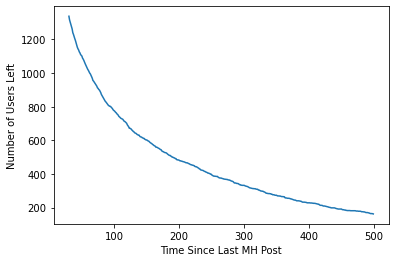

In [104]:
num_users = []
for i in range(30,500):
    num_users.append(mh_users[mh_users['time_since_last_mh']>i].shape[0])
    
fig = plt.figure()
ax = plt.axes()

ax.plot(list(range(30,500)), num_users);
plt.xlabel('Time Since Last MH Post')
plt.ylabel('Number of Users Left')

<AxesSubplot:>

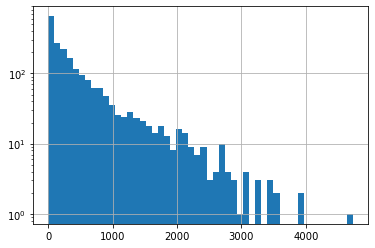

In [91]:
mh_users.time_since_first.hist(bins = 50, log = True)

<AxesSubplot:>

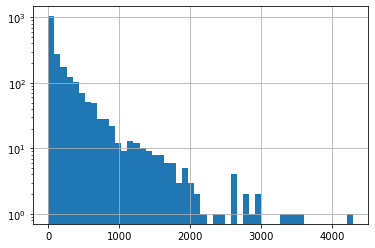

In [92]:
mh_users.time_since_first_mh.hist(bins = 50, log = True)

<AxesSubplot:>

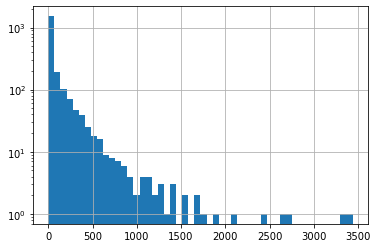

In [93]:
mh_users.time_since_last_mh.hist(bins = 50, log = True)

### Time Difference
Visualizing the difference between the first SuicideWatch post and a MH post.

Here we need to get users that have made a post and have made comments. It is clear that there are some users that make comments on SW before they eventually make a post there. We will take into account their first SW activity and their first SW post. 

In [10]:
# data with only the SW posts and comments.
only_sw_act = metadata[(metadata.username.isin(SW_users))&(metadata['subreddit']=='SuicideWatch')]
only_sw_post = metadata[(metadata.username.isin(SW_users))&(metadata['subreddit']=='SuicideWatch')&(metadata['type']==1)]

# data with only MH posts and comments
only_mh = metadata[metadata['subreddit']!= 'SuicideWatch']

In [11]:
display(only_mh.shape, only_sw_act.shape, only_sw_post.shape)

(1687005, 8)

(35283, 8)

(7961, 8)

In [18]:
first_sw_post = only_sw_post.loc[(only_sw_post.groupby('username')['date'].idxmin())]
first_sw_act = only_sw_act.loc[(only_sw_act.groupby('username')['date'].idxmin())]
display(first_sw_post.shape, first_sw_act.shape)

(2154, 8)

(2154, 8)

This makes sense as there should be the same number of users as we have filtered on users that have actually eventually made a post on SW.

In [19]:
sw_date = pd.merge(first_sw_act[['username','date']], first_sw_post[['username','date']], on = 'username')
sw_date.columns = ['username','sw_act_date','sw_post_date']
sw_date['post_act_diff'] = (sw_date['sw_post_date']-sw_date['sw_act_date']).astype('timedelta64[D]')

<AxesSubplot:>

count    2154.000000
mean       35.246518
std       149.486034
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      2337.000000
Name: post_act_diff, dtype: float64

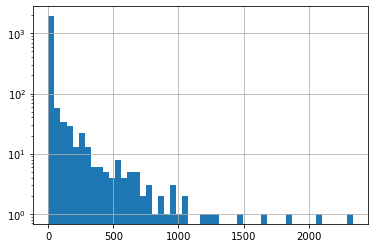

In [20]:
display(sw_date['post_act_diff'].hist(bins = 50, log = True), sw_date['post_act_diff'].describe())

Distribution of users that are posting comments on SW much before they eventually make a post there. I will make a decision here that the post is the best indicator of suicidal ideation of someone seeking out help or reaching out to people. But it is to note here that this is a linear progression of risk and we must think of it as such. 

This dataset will be used to filter out:
1. Any posts after the first post
2. Users that had their first activity as MH instead of SW
3. Any posts before an estabilised threshold after which it is useless to make any prediction.

In [21]:
filter_df = pd.merge(only_mh, sw_date, how = 'inner', on = 'username')
filter_df['post_date_diff'] = (filter_df['sw_post_date']-filter_df['date']).astype('timedelta64[D]')
filter_df['act_date_diff'] = (filter_df['sw_act_date']-filter_df['date']).astype('timedelta64[D]')

In [22]:
filter_df.head(n=3)

,username,type,subreddit,date,text,ups,downs,num_response,sw_act_date,sw_post_date,post_act_diff,post_date_diff,act_date_diff
0,-ANIME-GIRL-LOVER-,0,depression,2021-01-07 01:39:09,"Will do then thank you, luckily i think it was...",1,0,0,2020-09-18 05:10:45,2020-09-18 05:10:45,0.0,-111.0,-111.0
1,-ANIME-GIRL-LOVER-,0,Anxiety,2020-09-17 23:59:48,Yupe,4,0,0,2020-09-18 05:10:45,2020-09-18 05:10:45,0.0,0.0,0.0
2,-ANIME-GIRL-LOVER-,0,Anxiety,2020-09-17 23:47:32,Yeah for sure it feels like I don’t deserve it.,2,0,0,2020-09-18 05:10:45,2020-09-18 05:10:45,0.0,0.0,0.0


Let's first filter out any activity that happened after the first post.

In [23]:
mh_before_sw_users = filter_df[(filter_df['act_date_diff']>0)&(filter_df.username.isin(SW_users))].username.unique().tolist()
len(mh_before_sw_users)

1096

We need to be able to look into at least 48 hours into the past to be able to make accurate predictions and for this to be useful.

In [24]:
filter_df = filter_df[filter_df['post_date_diff']>2]

<AxesSubplot:>

count    12743.000000
mean       230.752492
std        335.665539
min          3.000000
25%         28.000000
50%         92.000000
75%        284.000000
max       3554.000000
Name: post_date_diff, dtype: float64

0.10     10.0
0.95    928.0
Name: post_date_diff, dtype: float64

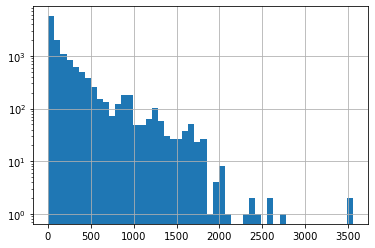

In [25]:
display(filter_df['post_date_diff'].hist(bins = 50, log = True),\
        filter_df['post_date_diff'].describe(),\
        filter_df['post_date_diff'].quantile([0.1,0.95]))

<AxesSubplot:>

count    12743.000000
mean       153.882210
std        333.677718
min      -1309.000000
25%          5.000000
50%         43.000000
75%        173.000000
max       3554.000000
Name: act_date_diff, dtype: float64

0.95    859.9
Name: act_date_diff, dtype: float64

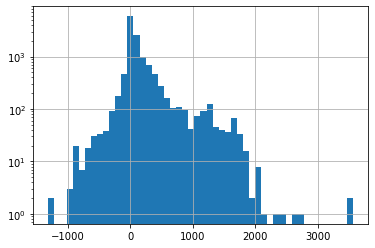

In [26]:
display(filter_df['act_date_diff'].hist(bins = 50, log = True),\
        filter_df['act_date_diff'].describe(),\
        filter_df['act_date_diff'].quantile([0.95]))

In [27]:
filter_df.subreddit.value_counts()

depression         6192
selfharm           2625
Anxiety            1463
lonely             1052
Needafriend         504
socialanxiety       347
depression_help     299
depressed           192
Anxietyhelp          69
Name: subreddit, dtype: int64

In [28]:
target_cohort_df = metadata[metadata.username.isin(mh_before_sw_users)]
target_cohort_df.head()

,username,type,subreddit,date,text,ups,downs,num_response
2,--XCrissCrossX--,0,SuicideWatch,2020-09-19 22:36:25,It's okay. What she did to me tore me to bits ...,1,0,0
3,--XCrissCrossX--,0,SuicideWatch,2020-09-19 22:03:34,"This is why I'm on this sub tonight. 10 years,...",2,0,0
4,--XCrissCrossX--,0,SuicideWatch,2020-03-27 15:53:43,I doubt I'll find things to pursue of live for...,3,0,0
5,--XCrissCrossX--,0,SuicideWatch,2020-03-27 15:21:52,"Yep, it's the only reason I'm still here. Figu...",4,0,0
13,-BabaGanoosh-,0,SuicideWatch,2020-12-23 09:47:55,:|,2,0,0


In [29]:
target_cohort_df.loc[(target_cohort_df.groupby('username')['date'].idxmin())].subreddit.value_counts()

depression         570
selfharm           163
Anxiety            112
lonely              77
Needafriend         56
socialanxiety       45
depression_help     35
depressed           27
Anxietyhelp         11
Name: subreddit, dtype: int64

In [30]:
target_cohort_df.shape

(34091, 8)

This confirms that our target cohort has made posts in MH subreddits before they eventually started posting on SW.

Now we need to filter the data based on a timespan. Based on the above distributions and some common sense on how we might want to use this. I wish to keep the data within 9 months of a timespan. So for example, given a person made a SW post in December, this would look back by March.

So I think a good enough threshold would be around 270 days.

In [31]:
target_cohort_df = pd.merge(target_cohort_df, sw_date, on ='username', how ='left')
target_cohort_df['act_date_diff'] = (target_cohort_df['sw_act_date']-target_cohort_df['date']).astype('timedelta64[D]')

In [32]:
final_target_df = target_cohort_df[target_cohort_df['act_date_diff']<=270]

In [33]:
display(final_target_df.head(3), final_target_df.shape)

,username,type,subreddit,date,text,ups,downs,num_response,sw_act_date,sw_post_date,post_act_diff,act_date_diff
0,--XCrissCrossX--,0,SuicideWatch,2020-09-19 22:36:25,It's okay. What she did to me tore me to bits ...,1,0,0,2020-03-07 22:06:04,2020-03-07 22:06:04,0.0,-197.0
1,--XCrissCrossX--,0,SuicideWatch,2020-09-19 22:03:34,"This is why I'm on this sub tonight. 10 years,...",2,0,0,2020-03-07 22:06:04,2020-03-07 22:06:04,0.0,-196.0
2,--XCrissCrossX--,0,SuicideWatch,2020-03-27 15:53:43,I doubt I'll find things to pursue of live for...,3,0,0,2020-03-07 22:06:04,2020-03-07 22:06:04,0.0,-20.0


(31772, 12)

In [34]:
final_target_df.to_csv('final_target_df.csv', index = False)

In [35]:
final_target_df.groupby('subreddit').count()

,username,type,date,text,ups,downs,num_response,sw_act_date,sw_post_date,post_act_diff,act_date_diff
subreddit,,,,,,,,,,,
Anxiety,1772,1772,1772,1772,1772,1772,1772,1772,1772,1772,1772
Anxietyhelp,90,90,90,90,90,90,90,90,90,90,90
Needafriend,575,575,575,575,575,575,575,575,575,575,575
SuicideWatch,10784,10784,10784,10784,10784,10784,10784,10784,10784,10784,10784
depressed,397,397,397,397,397,397,397,397,397,397,397
depression,10381,10381,10381,10381,10381,10381,10381,10381,10381,10381,10381
depression_help,572,572,572,572,572,572,572,572,572,572,572
lonely,1736,1736,1736,1736,1736,1736,1736,1736,1736,1736,1736
selfharm,4897,4897,4897,4897,4897,4897,4897,4897,4897,4897,4897


In [36]:
final_target_df.groupby('subreddit').nunique()

,username,type,date,text,ups,downs,num_response,sw_act_date,sw_post_date,post_act_diff,act_date_diff
subreddit,,,,,,,,,,,
Anxiety,228,2,1771,1737,61,1,36,228,228,42,509
Anxietyhelp,27,2,90,89,12,1,6,27,27,6,55
Needafriend,124,2,574,553,28,1,15,124,124,28,268
SuicideWatch,1096,2,10783,10295,152,1,55,1096,1096,132,859
depressed,90,2,397,382,34,1,23,90,90,18,159
depression,689,2,10378,9908,157,1,67,689,689,100,1079
depression_help,91,2,572,551,33,1,21,91,91,18,235
lonely,196,2,1736,1694,71,1,33,196,196,42,486
selfharm,242,2,4896,4740,143,1,42,242,242,47,676


<AxesSubplot:>

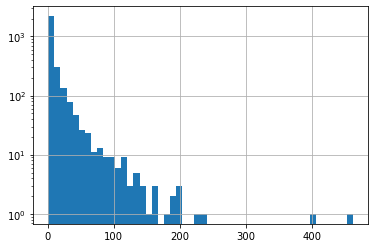

In [37]:
final_target_df.groupby(['username','subreddit']).count()['type'].hist(bins = 50, log = True)

This represents number of posts per subreddit per user. But I think this needs to be further filtered by looking at posts other than SW.

In [38]:
final_target_df[(final_target_df['subreddit']!='SuicideWatch')&(final_target_df['type']!=1)].groupby(['username','subreddit']).count()['type'].describe()#.hist(bins = 50, log = True)

count    1462.000000
mean       10.598495
std        22.945868
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       399.000000
Name: type, dtype: float64